In [54]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [55]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [56]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# loading dataset


In [57]:
df_train = pd.read_csv("/content/drive/MyDrive/mnist_train.csv")
df_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
df_test_val = pd.read_csv("/content/drive/MyDrive/mnist_test.csv")
df_test_val.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df = pd.concat([df_train, df_test_val], axis=0)
df_train, temp = train_test_split(df, train_size=0.60, random_state=42)
df_val, df_test = train_test_split(temp, test_size=0.50, random_state=42)

In [60]:
X_train = df_train.drop('label', axis=1).values
X_train = X_train / 255.0
y_train = df_train['label'].values

X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28)
y_train = torch.tensor(y_train, dtype=torch.long)

dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [61]:
X_val = df_val.drop('label', axis=1).values
X_val = X_val / 255.0
y_val = df_val['label'].values

X_val = torch.tensor(X_val, dtype=torch.float32).view(-1, 1, 28, 28)
y_val = torch.tensor(y_val, dtype=torch.long)

dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [62]:
X_test = df_test.drop('label', axis=1).values
X_test = X_test / 255.0
y_test = df_test['label'].values

X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 28, 28)
y_test = torch.tensor(y_test, dtype=torch.long)

dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

### Creating cnn architecture

In [63]:
class CNN_dropout(nn.Module):
    def __init__(self, rate):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.dropout = nn.Dropout(rate)
        self.fc1 = nn.Linear(32 * 5* 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)
        x = torch.flatten(x, 1) # flattening the matrix
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

## Function for early stopping

In [64]:
class EarlyStopper:
    def __init__(self, patience=1, threshold=0):
        self.patience = patience
        self.threshold = threshold
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stopping(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.threshold):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## training function

In [65]:
def trainCNN(Model):
    model = Model.to(device)
    lossType = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_losses = []
    val_losses = []
    early_stopper = EarlyStopper(patience=3, threshold=5)#improve by 5 for 3 concec epochs

    for epoch in range(20):
        model.train()
        running_loss = 0
        epoch_loss = 0.0
        # tuple of the inputs and their label
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()  # resetting gradients
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # using gpu
            outputs = model(inputs)  # forward propagation
            loss = lossType(outputs, labels)
            loss.backward()  # backward propagation
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / (i + 1)
        train_losses.append(avg_train_loss)

        avg_val_loss = evaluateValLoss(model)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        if early_stopper.early_stopping(avg_val_loss):
          break

    plot_losses(train_losses, val_losses)
    return model

## Get validation loss

In [66]:
def evaluateValLoss(model):
  total_loss=0
  samples=0
  model.eval()
  with torch.no_grad():
      for data in val_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device) #using gpu
          outputs = model(images)
          loss = nn.CrossEntropyLoss()(outputs,labels)
          total_loss += loss.item() * images.size(0)
          samples += images.size(0)

  final_loss = total_loss/samples
  return final_loss

In [67]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Model Evaluation functions

In [68]:
def evaluateValCNN(model):
    total=0
    correct=0
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #using gpu
            outputs = model(images)
            # returns max value & the indeces of the values
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100*correct)/total
    return accuracy

In [69]:
def evaluateTestCNN(model):
    total=0
    correct=0
    model.eval()
    all_labels_list = []
    all_predicted_list = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #using gpu
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels_list.append(labels.cpu().numpy())
            all_predicted_list.append(predicted.cpu().numpy())
    accuracy = (100*correct)/total
    print(f"Accuracy: {accuracy}") #99.18 with momentum = 0.9, without 98.52 no droprate

    print(f"\nFinal Test Accuracy: {100 * correct / total:.2f}%")
    all_labels = np.concatenate(all_labels_list)
    all_predicted = np.concatenate(all_predicted_list)
    cm = confusion_matrix(all_labels, all_predicted)

    class_names = [str(i) for i in range(10)] # all digits
    plt.figure(figsize=(6, 4))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    all_preds_np = np.array(all_predicted)
    all_labels_np = np.array(all_labels)

    misclassified_indices = np.where(all_preds_np != all_labels_np)[0]

    print(f"Total misclassified examples: {len(misclassified_indices)}")

    plt.figure(figsize=(10, 8))
    # You can change '15' to however many you want to show
    for i, index in enumerate(misclassified_indices[:15]):
        plt.subplot(3, 5, i + 1)

        # Get the image from the X_test tensor
        image = X_test[index].squeeze().numpy()
        # Get the true label from the original df_test DataFrame
        true_label = df_test.iloc[index]['label']


        if image.shape[0] == 1:
            image = image.squeeze()

        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {all_preds_np[index]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return accuracy

## Drop out rates tuning

In [70]:
rates = [0, 0.1, 0.3, 0.5, 0.7] # 0 drop rate is no reg
def tuneDropOutRates(modelClass):
    accuracies = []
    for Rate in rates:
        modelType = modelClass(Rate)
        model = trainCNN(modelType)
        accuracy = evaluateValCNN(model)
        accuracies.append(accuracy)
    for i in range(len(accuracies)):
        print(f"For rate: {rates[i]} Accuracy = {accuracies[i]}\n")

#For rate: 0 Accuracy = 99.2
# For rate: 0.1 Accuracy = 98.9
# For rate: 0.3 Accuracy = 98.5
# For rate: 0.5 Accuracy = 97.68
# For rate: 0.7 Accuracy = 94.92

Epoch 1: Train Loss = 2.0313, Val Loss = 0.8639
Epoch 2: Train Loss = 0.4721, Val Loss = 0.3532
Epoch 3: Train Loss = 0.3064, Val Loss = 0.2721
Epoch 4: Train Loss = 0.2342, Val Loss = 0.2036
Epoch 5: Train Loss = 0.1866, Val Loss = 0.1735
Epoch 6: Train Loss = 0.1521, Val Loss = 0.1354
Epoch 7: Train Loss = 0.1280, Val Loss = 0.1206
Epoch 8: Train Loss = 0.1121, Val Loss = 0.1106
Epoch 9: Train Loss = 0.0991, Val Loss = 0.0965
Epoch 10: Train Loss = 0.0901, Val Loss = 0.0989
Epoch 11: Train Loss = 0.0826, Val Loss = 0.0837
Epoch 12: Train Loss = 0.0766, Val Loss = 0.0821
Epoch 13: Train Loss = 0.0720, Val Loss = 0.0756
Epoch 14: Train Loss = 0.0682, Val Loss = 0.0751
Epoch 15: Train Loss = 0.0636, Val Loss = 0.0715
Epoch 16: Train Loss = 0.0601, Val Loss = 0.0698
Epoch 17: Train Loss = 0.0564, Val Loss = 0.0639
Epoch 18: Train Loss = 0.0543, Val Loss = 0.0609
Epoch 19: Train Loss = 0.0519, Val Loss = 0.0622
Epoch 20: Train Loss = 0.0495, Val Loss = 0.0585


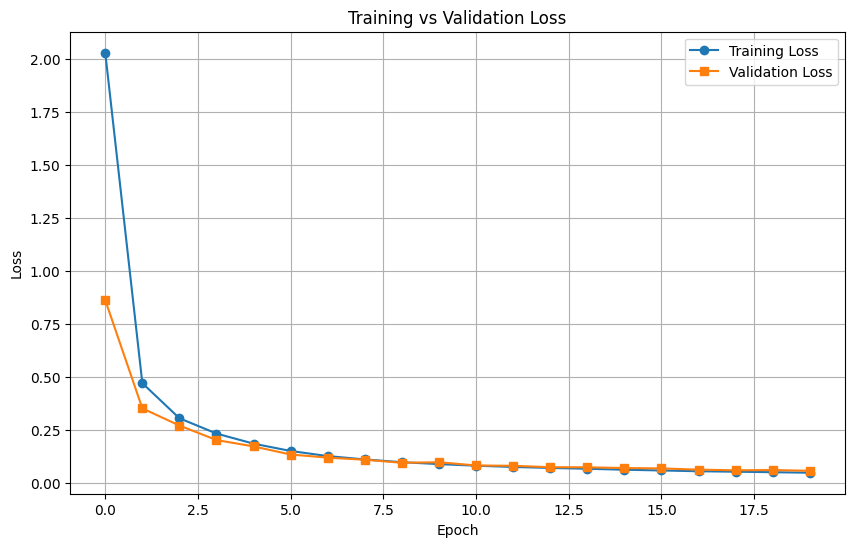

Epoch 1: Train Loss = 1.5647, Val Loss = 0.4653
Epoch 2: Train Loss = 0.3875, Val Loss = 0.2875
Epoch 3: Train Loss = 0.2668, Val Loss = 0.2110
Epoch 4: Train Loss = 0.1996, Val Loss = 0.1568
Epoch 5: Train Loss = 0.1596, Val Loss = 0.1308
Epoch 6: Train Loss = 0.1383, Val Loss = 0.1126
Epoch 7: Train Loss = 0.1206, Val Loss = 0.1090
Epoch 8: Train Loss = 0.1107, Val Loss = 0.0937
Epoch 9: Train Loss = 0.1001, Val Loss = 0.0872
Epoch 10: Train Loss = 0.0943, Val Loss = 0.0800
Epoch 11: Train Loss = 0.0858, Val Loss = 0.0771
Epoch 12: Train Loss = 0.0823, Val Loss = 0.0736
Epoch 13: Train Loss = 0.0768, Val Loss = 0.0677
Epoch 14: Train Loss = 0.0735, Val Loss = 0.0664
Epoch 15: Train Loss = 0.0687, Val Loss = 0.0624
Epoch 16: Train Loss = 0.0664, Val Loss = 0.0665
Epoch 17: Train Loss = 0.0630, Val Loss = 0.0584
Epoch 18: Train Loss = 0.0618, Val Loss = 0.0561
Epoch 19: Train Loss = 0.0586, Val Loss = 0.0590
Epoch 20: Train Loss = 0.0566, Val Loss = 0.0532


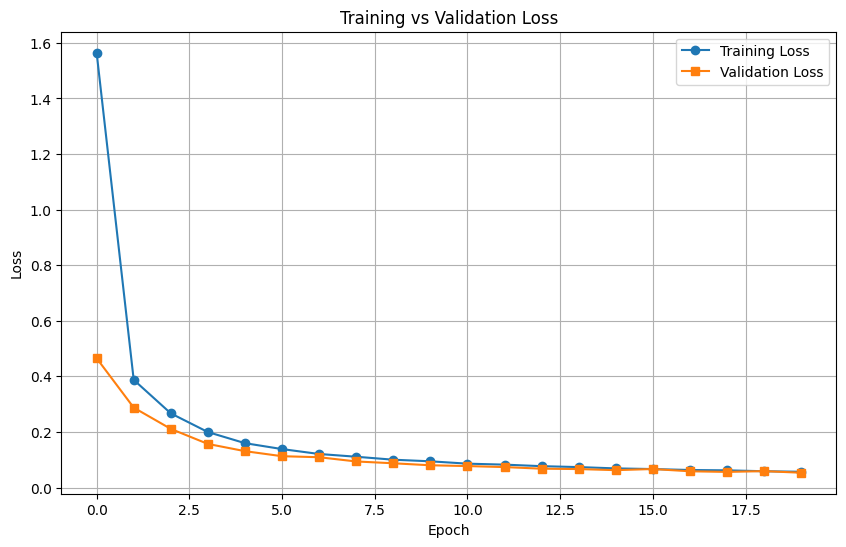

Epoch 1: Train Loss = 1.9368, Val Loss = 0.7739
Epoch 2: Train Loss = 0.6273, Val Loss = 0.3984
Epoch 3: Train Loss = 0.4067, Val Loss = 0.2719
Epoch 4: Train Loss = 0.2866, Val Loss = 0.1985
Epoch 5: Train Loss = 0.2208, Val Loss = 0.1522
Epoch 6: Train Loss = 0.1803, Val Loss = 0.1273
Epoch 7: Train Loss = 0.1566, Val Loss = 0.1133
Epoch 8: Train Loss = 0.1431, Val Loss = 0.1037
Epoch 9: Train Loss = 0.1288, Val Loss = 0.0947
Epoch 10: Train Loss = 0.1160, Val Loss = 0.0913
Epoch 11: Train Loss = 0.1119, Val Loss = 0.0807
Epoch 12: Train Loss = 0.1050, Val Loss = 0.0783
Epoch 13: Train Loss = 0.0976, Val Loss = 0.0747
Epoch 14: Train Loss = 0.0963, Val Loss = 0.0712
Epoch 15: Train Loss = 0.0917, Val Loss = 0.0688
Epoch 16: Train Loss = 0.0884, Val Loss = 0.0663
Epoch 17: Train Loss = 0.0833, Val Loss = 0.0656
Epoch 18: Train Loss = 0.0801, Val Loss = 0.0604
Epoch 19: Train Loss = 0.0774, Val Loss = 0.0595
Epoch 20: Train Loss = 0.0752, Val Loss = 0.0572


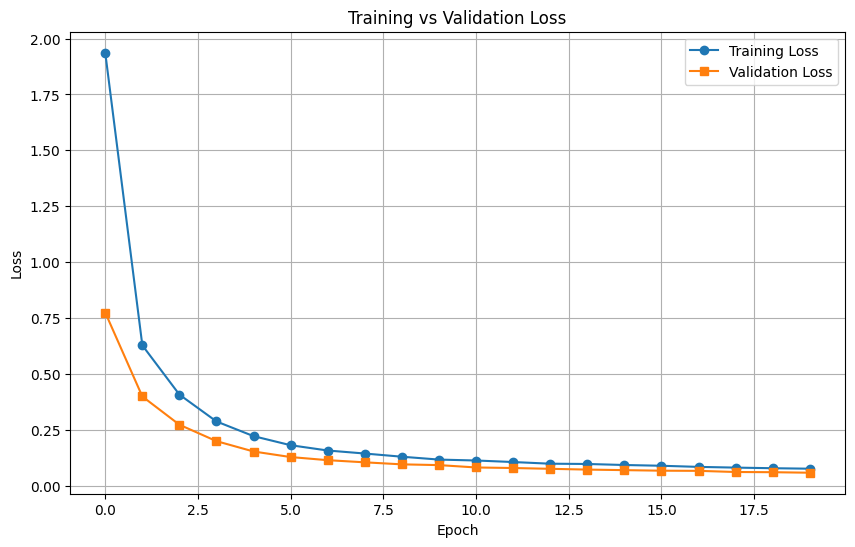

Epoch 1: Train Loss = 1.7756, Val Loss = 0.6489
Epoch 2: Train Loss = 0.5931, Val Loss = 0.3252
Epoch 3: Train Loss = 0.3643, Val Loss = 0.2201
Epoch 4: Train Loss = 0.2756, Val Loss = 0.1723
Epoch 5: Train Loss = 0.2327, Val Loss = 0.1499
Epoch 6: Train Loss = 0.1999, Val Loss = 0.1288
Epoch 7: Train Loss = 0.1830, Val Loss = 0.1168
Epoch 8: Train Loss = 0.1624, Val Loss = 0.1063
Epoch 9: Train Loss = 0.1546, Val Loss = 0.1005
Epoch 10: Train Loss = 0.1446, Val Loss = 0.0923
Epoch 11: Train Loss = 0.1381, Val Loss = 0.0877
Epoch 12: Train Loss = 0.1307, Val Loss = 0.0859
Epoch 13: Train Loss = 0.1246, Val Loss = 0.0814
Epoch 14: Train Loss = 0.1210, Val Loss = 0.0767
Epoch 15: Train Loss = 0.1177, Val Loss = 0.0740
Epoch 16: Train Loss = 0.1106, Val Loss = 0.0719
Epoch 17: Train Loss = 0.1088, Val Loss = 0.0700
Epoch 18: Train Loss = 0.1024, Val Loss = 0.0664
Epoch 19: Train Loss = 0.1018, Val Loss = 0.0636
Epoch 20: Train Loss = 0.0970, Val Loss = 0.0627


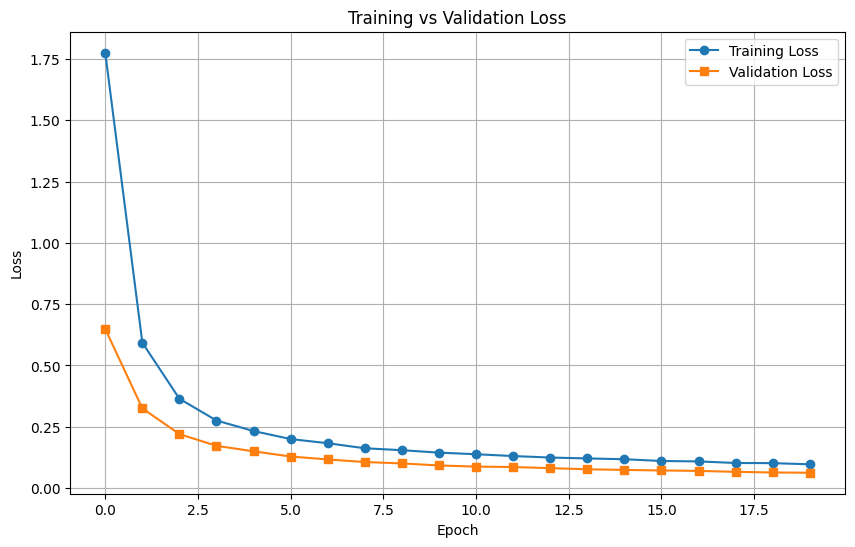

Epoch 1: Train Loss = 2.1868, Val Loss = 1.4381
Epoch 2: Train Loss = 0.8598, Val Loss = 0.3871
Epoch 3: Train Loss = 0.4615, Val Loss = 0.2570
Epoch 4: Train Loss = 0.3518, Val Loss = 0.1965
Epoch 5: Train Loss = 0.2969, Val Loss = 0.1685
Epoch 6: Train Loss = 0.2634, Val Loss = 0.1494
Epoch 7: Train Loss = 0.2435, Val Loss = 0.1344
Epoch 8: Train Loss = 0.2254, Val Loss = 0.1249
Epoch 9: Train Loss = 0.2104, Val Loss = 0.1180
Epoch 10: Train Loss = 0.1980, Val Loss = 0.1086
Epoch 11: Train Loss = 0.1910, Val Loss = 0.1024
Epoch 12: Train Loss = 0.1782, Val Loss = 0.0968
Epoch 13: Train Loss = 0.1715, Val Loss = 0.0935
Epoch 14: Train Loss = 0.1627, Val Loss = 0.0886
Epoch 15: Train Loss = 0.1604, Val Loss = 0.0853
Epoch 16: Train Loss = 0.1575, Val Loss = 0.0811
Epoch 17: Train Loss = 0.1490, Val Loss = 0.0797
Epoch 18: Train Loss = 0.1450, Val Loss = 0.0764
Epoch 19: Train Loss = 0.1408, Val Loss = 0.0732
Epoch 20: Train Loss = 0.1404, Val Loss = 0.0720


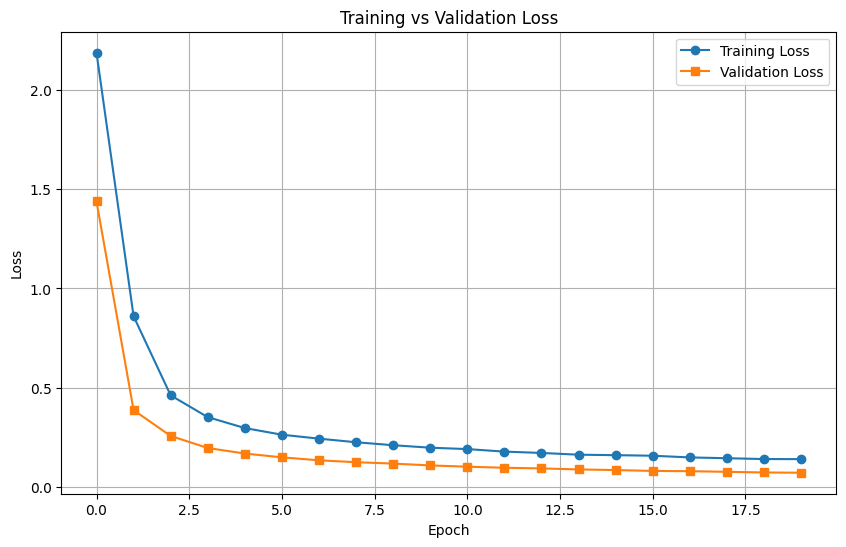

For rate: 0 Accuracy = 98.17857142857143

For rate: 0.1 Accuracy = 98.40714285714286

For rate: 0.3 Accuracy = 98.25

For rate: 0.5 Accuracy = 98.02857142857142

For rate: 0.7 Accuracy = 97.87857142857143



In [71]:
tuneDropOutRates(modelClass=CNN_dropout)

# CNN with batch normalization

In [72]:
class CNN_batchNormalization(nn.Module):
    def __init__(self, rate):
        super().__init__()
        self.dropout = nn.Dropout(rate)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(32 * 5* 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

Epoch 1: Train Loss = 0.5288, Val Loss = 0.1695
Epoch 2: Train Loss = 0.1316, Val Loss = 0.1125
Epoch 3: Train Loss = 0.0930, Val Loss = 0.0905
Epoch 4: Train Loss = 0.0755, Val Loss = 0.0762
Epoch 5: Train Loss = 0.0648, Val Loss = 0.0711
Epoch 6: Train Loss = 0.0570, Val Loss = 0.0643
Epoch 7: Train Loss = 0.0508, Val Loss = 0.0604
Epoch 8: Train Loss = 0.0466, Val Loss = 0.0561
Epoch 9: Train Loss = 0.0428, Val Loss = 0.0583
Epoch 10: Train Loss = 0.0393, Val Loss = 0.0554
Epoch 11: Train Loss = 0.0369, Val Loss = 0.0504
Epoch 12: Train Loss = 0.0341, Val Loss = 0.0526
Epoch 13: Train Loss = 0.0321, Val Loss = 0.0500
Epoch 14: Train Loss = 0.0307, Val Loss = 0.0479
Epoch 15: Train Loss = 0.0287, Val Loss = 0.0478
Epoch 16: Train Loss = 0.0272, Val Loss = 0.0475
Epoch 17: Train Loss = 0.0258, Val Loss = 0.0458
Epoch 18: Train Loss = 0.0246, Val Loss = 0.0464
Epoch 19: Train Loss = 0.0239, Val Loss = 0.0440
Epoch 20: Train Loss = 0.0219, Val Loss = 0.0432


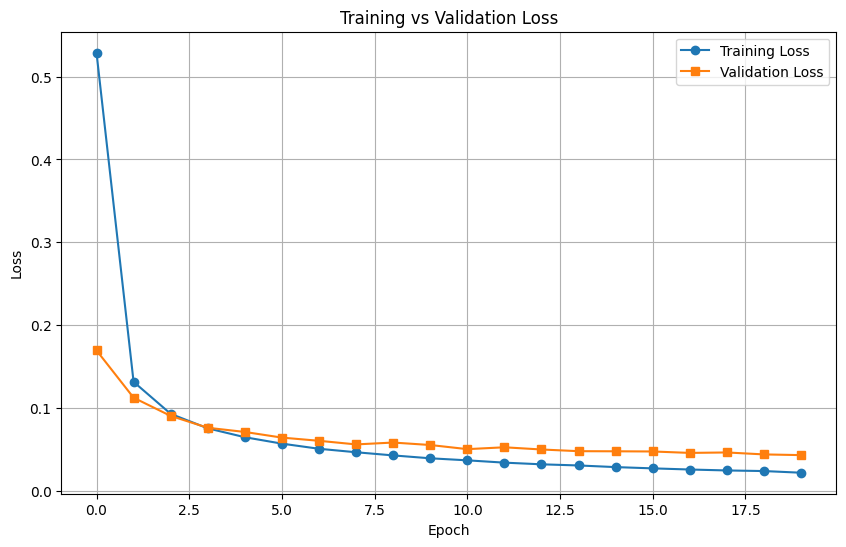

Epoch 1: Train Loss = 0.5493, Val Loss = 0.2098
Epoch 2: Train Loss = 0.1592, Val Loss = 0.1402
Epoch 3: Train Loss = 0.1180, Val Loss = 0.1148
Epoch 4: Train Loss = 0.0969, Val Loss = 0.1007
Epoch 5: Train Loss = 0.0829, Val Loss = 0.0903
Epoch 6: Train Loss = 0.0747, Val Loss = 0.0798
Epoch 7: Train Loss = 0.0683, Val Loss = 0.0713
Epoch 8: Train Loss = 0.0630, Val Loss = 0.0703
Epoch 9: Train Loss = 0.0584, Val Loss = 0.0595
Epoch 10: Train Loss = 0.0553, Val Loss = 0.0623
Epoch 11: Train Loss = 0.0525, Val Loss = 0.0580
Epoch 12: Train Loss = 0.0499, Val Loss = 0.0526
Epoch 13: Train Loss = 0.0474, Val Loss = 0.0497
Epoch 14: Train Loss = 0.0459, Val Loss = 0.0558
Epoch 15: Train Loss = 0.0437, Val Loss = 0.0514
Epoch 16: Train Loss = 0.0401, Val Loss = 0.0519
Epoch 17: Train Loss = 0.0405, Val Loss = 0.0486
Epoch 18: Train Loss = 0.0385, Val Loss = 0.0463
Epoch 19: Train Loss = 0.0374, Val Loss = 0.0512
Epoch 20: Train Loss = 0.0361, Val Loss = 0.0485


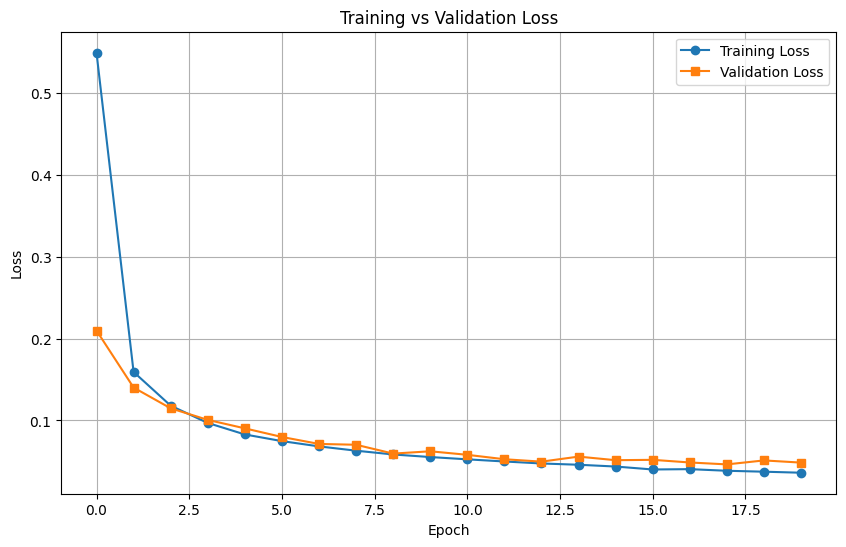

Epoch 1: Train Loss = 0.6297, Val Loss = 0.3705
Epoch 2: Train Loss = 0.2120, Val Loss = 0.2359
Epoch 3: Train Loss = 0.1582, Val Loss = 0.1866
Epoch 4: Train Loss = 0.1302, Val Loss = 0.1687
Epoch 5: Train Loss = 0.1145, Val Loss = 0.1530
Epoch 6: Train Loss = 0.1037, Val Loss = 0.1391
Epoch 7: Train Loss = 0.0950, Val Loss = 0.1243
Epoch 8: Train Loss = 0.0881, Val Loss = 0.1302
Epoch 9: Train Loss = 0.0822, Val Loss = 0.1145
Epoch 10: Train Loss = 0.0770, Val Loss = 0.1196
Epoch 11: Train Loss = 0.0736, Val Loss = 0.1200
Epoch 12: Train Loss = 0.0704, Val Loss = 0.1132
Epoch 13: Train Loss = 0.0668, Val Loss = 0.1181
Epoch 14: Train Loss = 0.0633, Val Loss = 0.1112
Epoch 15: Train Loss = 0.0619, Val Loss = 0.1066
Epoch 16: Train Loss = 0.0596, Val Loss = 0.0909
Epoch 17: Train Loss = 0.0570, Val Loss = 0.0964
Epoch 18: Train Loss = 0.0543, Val Loss = 0.0842
Epoch 19: Train Loss = 0.0538, Val Loss = 0.1003
Epoch 20: Train Loss = 0.0519, Val Loss = 0.1000


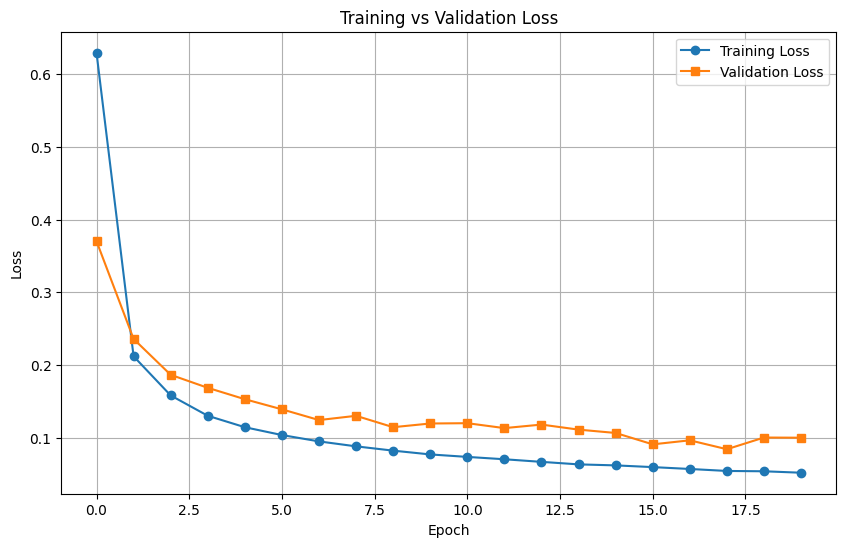

Epoch 1: Train Loss = 0.6964, Val Loss = 0.9704
Epoch 2: Train Loss = 0.2732, Val Loss = 0.8956
Epoch 3: Train Loss = 0.2042, Val Loss = 0.8435
Epoch 4: Train Loss = 0.1699, Val Loss = 0.7729
Epoch 5: Train Loss = 0.1479, Val Loss = 0.7382
Epoch 6: Train Loss = 0.1345, Val Loss = 0.6686
Epoch 7: Train Loss = 0.1245, Val Loss = 0.6969
Epoch 8: Train Loss = 0.1142, Val Loss = 0.7161
Epoch 9: Train Loss = 0.1100, Val Loss = 0.6824
Epoch 10: Train Loss = 0.1030, Val Loss = 0.6783
Epoch 11: Train Loss = 0.1003, Val Loss = 0.6597
Epoch 12: Train Loss = 0.0939, Val Loss = 0.6263
Epoch 13: Train Loss = 0.0906, Val Loss = 0.6167
Epoch 14: Train Loss = 0.0884, Val Loss = 0.6327
Epoch 15: Train Loss = 0.0867, Val Loss = 0.5706
Epoch 16: Train Loss = 0.0839, Val Loss = 0.5851
Epoch 17: Train Loss = 0.0812, Val Loss = 0.5836
Epoch 18: Train Loss = 0.0770, Val Loss = 0.5773
Epoch 19: Train Loss = 0.0772, Val Loss = 0.5840
Epoch 20: Train Loss = 0.0765, Val Loss = 0.5476


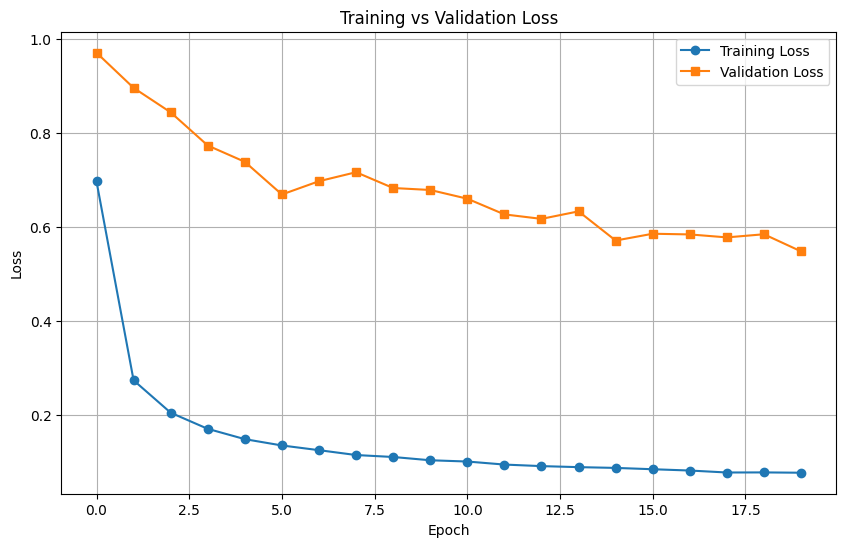

Epoch 1: Train Loss = 0.7963, Val Loss = 1.7891
Epoch 2: Train Loss = 0.3813, Val Loss = 1.7994
Epoch 3: Train Loss = 0.3039, Val Loss = 1.8423
Epoch 4: Train Loss = 0.2655, Val Loss = 1.8150
Epoch 5: Train Loss = 0.2386, Val Loss = 1.8233
Epoch 6: Train Loss = 0.2211, Val Loss = 1.8367
Epoch 7: Train Loss = 0.2093, Val Loss = 1.8427
Epoch 8: Train Loss = 0.1976, Val Loss = 1.8706
Epoch 9: Train Loss = 0.1904, Val Loss = 1.8463
Epoch 10: Train Loss = 0.1875, Val Loss = 1.7927
Epoch 11: Train Loss = 0.1782, Val Loss = 1.8503
Epoch 12: Train Loss = 0.1745, Val Loss = 1.8233
Epoch 13: Train Loss = 0.1697, Val Loss = 1.8919
Epoch 14: Train Loss = 0.1651, Val Loss = 1.8155
Epoch 15: Train Loss = 0.1582, Val Loss = 1.8153
Epoch 16: Train Loss = 0.1543, Val Loss = 1.8510
Epoch 17: Train Loss = 0.1562, Val Loss = 1.8181
Epoch 18: Train Loss = 0.1538, Val Loss = 1.8300
Epoch 19: Train Loss = 0.1525, Val Loss = 1.8332
Epoch 20: Train Loss = 0.1473, Val Loss = 1.8927


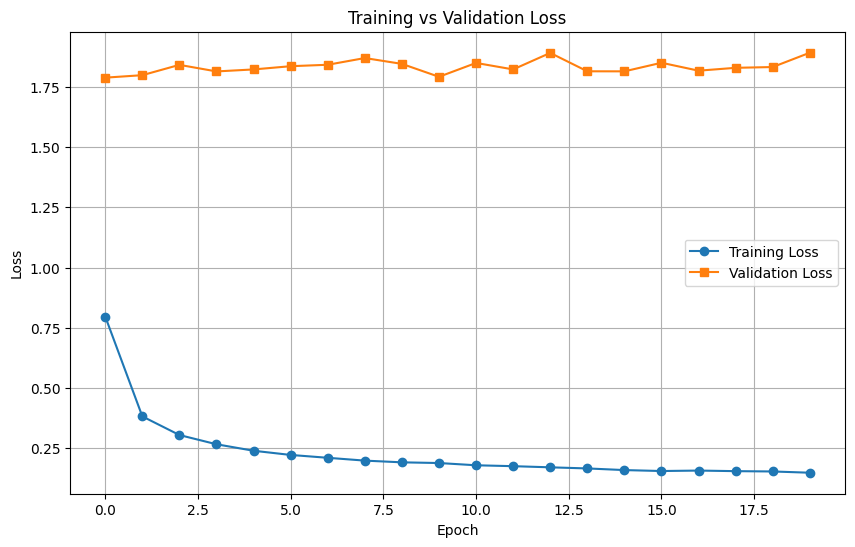

For rate: 0 Accuracy = 98.52857142857142

For rate: 0.1 Accuracy = 98.41428571428571

For rate: 0.3 Accuracy = 97.33571428571429

For rate: 0.5 Accuracy = 84.63571428571429

For rate: 0.7 Accuracy = 39.47142857142857



In [73]:
tuneDropOutRates(modelClass=CNN_batchNormalization)
# For rate: 0 Accuracy = 99.12
# For rate: 0.1 Accuracy = 98.94
# For rate: 0.3 Accuracy = 98.74
# For rate: 0.5 Accuracy = 97.62
# For rate: 0.7 Accuracy = 95.84

# Final testing

Epoch 1: Train Loss = 2.2707, Val Loss = 2.1456
Epoch 2: Train Loss = 1.0748, Val Loss = 0.4652
Epoch 3: Train Loss = 0.4609, Val Loss = 0.2998
Epoch 4: Train Loss = 0.3194, Val Loss = 0.2144
Epoch 5: Train Loss = 0.2407, Val Loss = 0.1731
Epoch 6: Train Loss = 0.1908, Val Loss = 0.1408
Epoch 7: Train Loss = 0.1650, Val Loss = 0.1238
Epoch 8: Train Loss = 0.1478, Val Loss = 0.1138
Epoch 9: Train Loss = 0.1321, Val Loss = 0.0996
Epoch 10: Train Loss = 0.1232, Val Loss = 0.0930
Epoch 11: Train Loss = 0.1121, Val Loss = 0.0865
Epoch 12: Train Loss = 0.1068, Val Loss = 0.0822
Epoch 13: Train Loss = 0.1001, Val Loss = 0.0792
Epoch 14: Train Loss = 0.0953, Val Loss = 0.0760
Epoch 15: Train Loss = 0.0896, Val Loss = 0.0718
Epoch 16: Train Loss = 0.0859, Val Loss = 0.0691
Epoch 17: Train Loss = 0.0837, Val Loss = 0.0652
Epoch 18: Train Loss = 0.0806, Val Loss = 0.0646
Epoch 19: Train Loss = 0.0767, Val Loss = 0.0624
Epoch 20: Train Loss = 0.0741, Val Loss = 0.0596


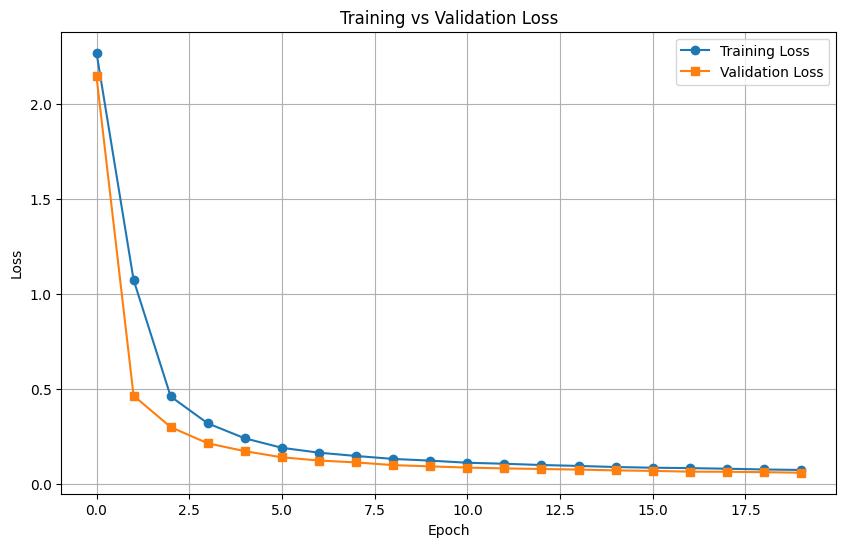

Epoch 1: Train Loss = 0.5478, Val Loss = 0.1900
Epoch 2: Train Loss = 0.1541, Val Loss = 0.1276
Epoch 3: Train Loss = 0.1140, Val Loss = 0.1002
Epoch 4: Train Loss = 0.0943, Val Loss = 0.0822
Epoch 5: Train Loss = 0.0831, Val Loss = 0.0784
Epoch 6: Train Loss = 0.0737, Val Loss = 0.0770
Epoch 7: Train Loss = 0.0679, Val Loss = 0.0664
Epoch 8: Train Loss = 0.0642, Val Loss = 0.0619
Epoch 9: Train Loss = 0.0592, Val Loss = 0.0640
Epoch 10: Train Loss = 0.0549, Val Loss = 0.0685
Epoch 11: Train Loss = 0.0535, Val Loss = 0.0644
Epoch 12: Train Loss = 0.0495, Val Loss = 0.0556
Epoch 13: Train Loss = 0.0480, Val Loss = 0.0543
Epoch 14: Train Loss = 0.0465, Val Loss = 0.0555
Epoch 15: Train Loss = 0.0438, Val Loss = 0.0498
Epoch 16: Train Loss = 0.0421, Val Loss = 0.0507
Epoch 17: Train Loss = 0.0402, Val Loss = 0.0505
Epoch 18: Train Loss = 0.0392, Val Loss = 0.0473
Epoch 19: Train Loss = 0.0376, Val Loss = 0.0438
Epoch 20: Train Loss = 0.0382, Val Loss = 0.0449


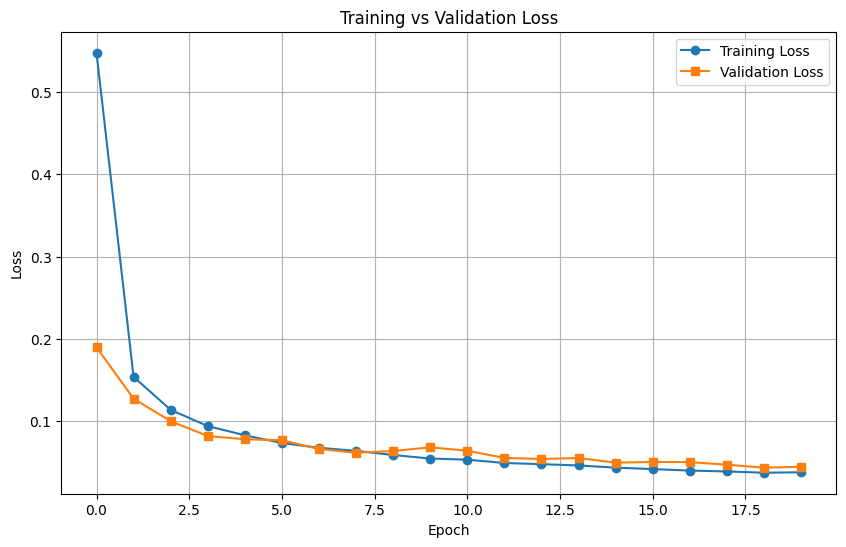

Accuracy: 98.02142857142857

Final Test Accuracy: 98.02%


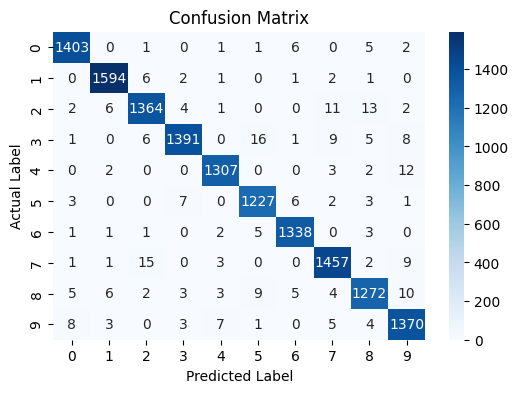

Total misclassified examples: 277


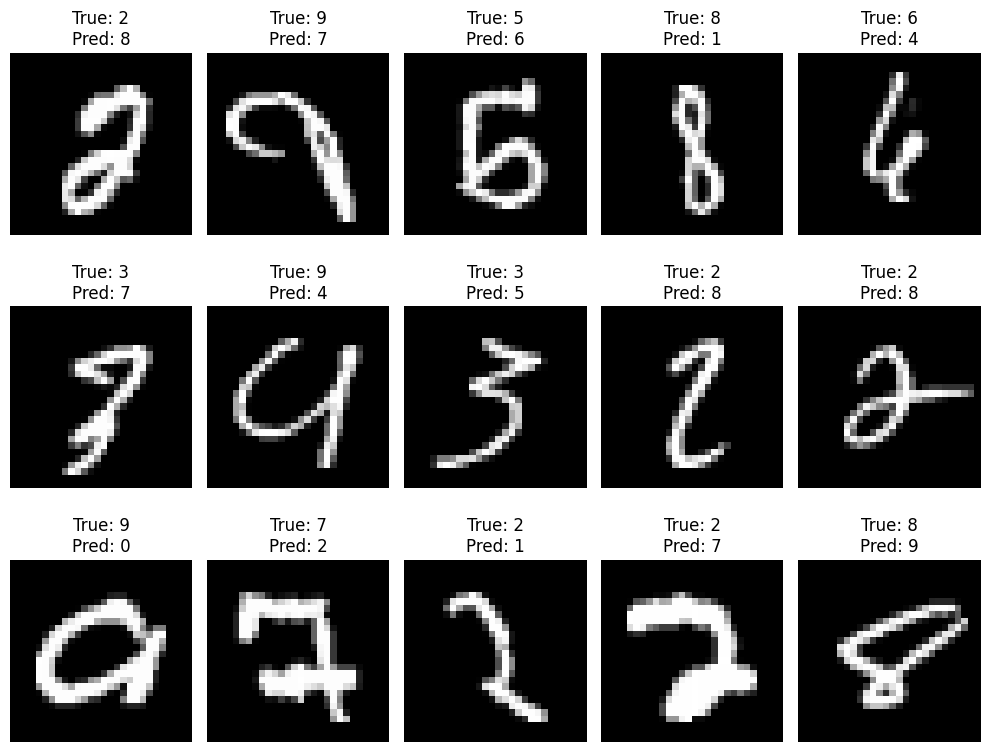

98.02142857142857
Accuracy: 98.32857142857142

Final Test Accuracy: 98.33%


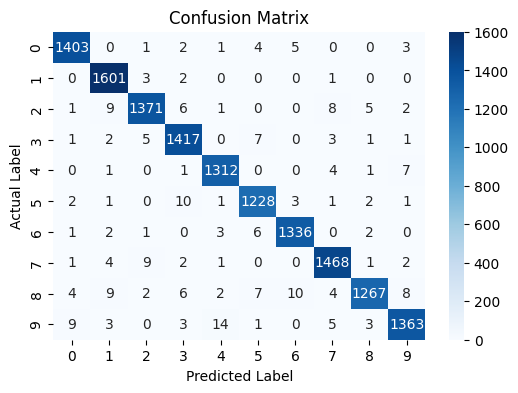

Total misclassified examples: 234


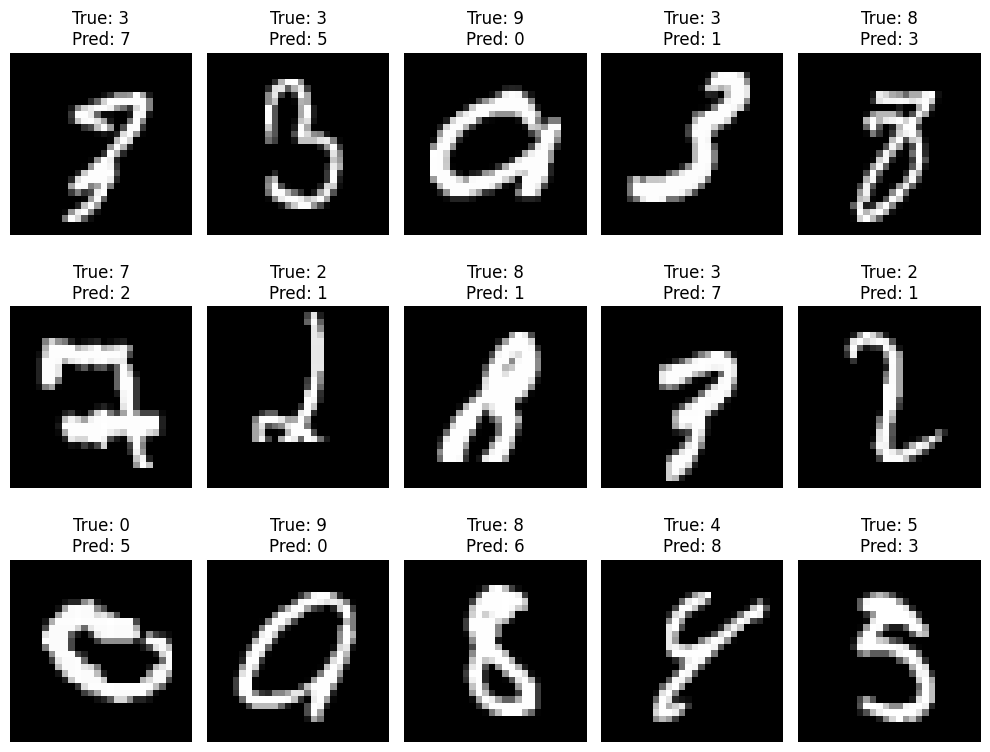

98.32857142857142


In [74]:
model_no_normalization = trainCNN(CNN_dropout(rate=0.3))
model_normalization = trainCNN(CNN_batchNormalization(rate=0.1))
print(evaluateTestCNN(model_no_normalization))
print(evaluateTestCNN(model_normalization))

Accuracy: 98.32857142857142

Final Test Accuracy: 98.33%


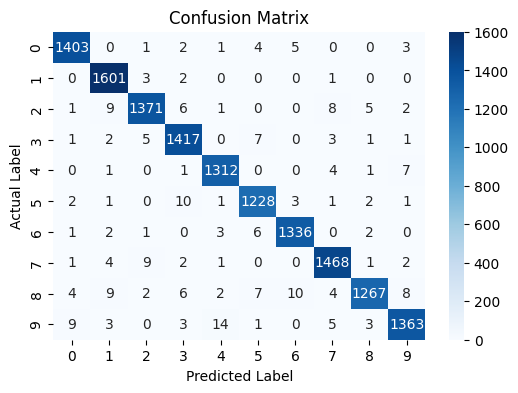

Total misclassified examples: 234


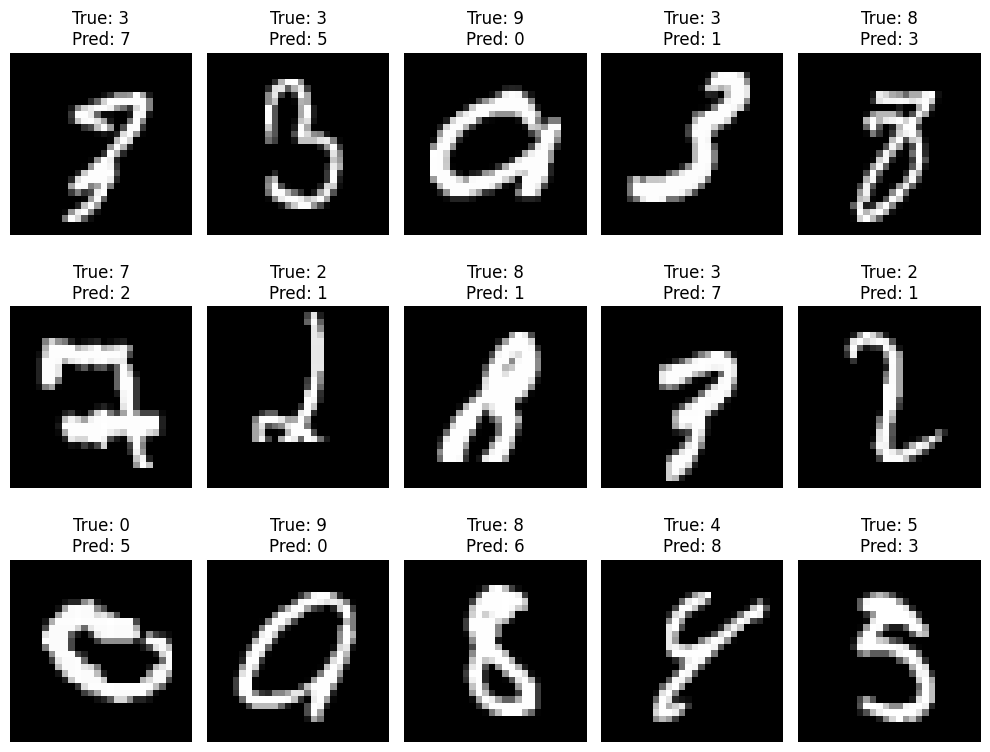

98.32857142857142


In [75]:
print(evaluateTestCNN(model_normalization))